# Bayesian Models

1. What are Bayesian Models
2. Independencies in Bayesian Networks
3. How is Bayesian Model encoding the Joint Distribution
4. How we do inference from Bayesian models
5. Types of methods for inference

Doing path-setting:

In [1]:
import os
import sys
from typing import *
from typing import Union, List, Any

from networkx.classes.reportviews import OutEdgeDataView, OutEdgeView
from pgmpy.independencies import Independencies
import itertools

os.getcwd()
# Setting the baseline:
os.chdir('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP')


curPath: str = os.getcwd() + "/src/PgmpyStudy/"

dataPath: str = curPath + "data/"

imagePath: str = curPath + 'images/'

print("curPath = ", curPath, "\n")
print("dataPath = ", dataPath, "\n")
print('imagePath = ', imagePath, "\n")


# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
# For being able to import files within PgmpyStudy folder
sys.path.append(curPath)

sys.path

curPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/ 

dataPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/data/ 

imagePath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/images/ 



['/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python37.zip',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/lib-dynload',
 '',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/IPython/extensions',
 '/home/statisticallyfit/.ipython',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/utils/',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/']

Science-related imports:

In [2]:
from IPython.display import Image

In [3]:
# Declaring type aliases for clarity:
Variable = str
Value = str

## 1. What are Bayesian Models
**Definition:** A **bayesian network** or **probabilistic directed acyclic graphical model** is a **probabilistic graphical model (PGM)** that represents a set of random variables and their conditional dependencies via a **directed acyclic graph (DAG)**.

Bayesian networks are mostly used when we want to represent causal relationship between the random variables. Bayesian networks are parametrized using **conditional probability distributions (CPD)**. Each node in the network is parametrized using $P(\text{node} \; | \; \text{node}_\text{parent})$, where $\text{node}_\text{parent}$ represents the parents of the $\text{node}$ in the network.

Example: take the student model:

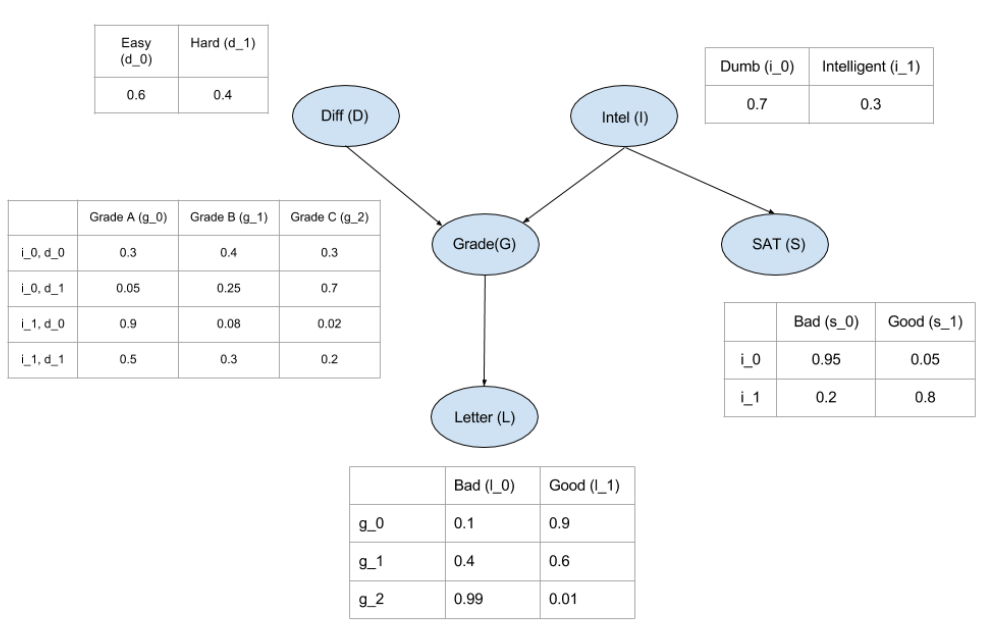

In [4]:
Image(filename = imagePath + 'grademodel.png')

In pgmpy we define the network structure and the CPDs separately and only then associate them with the structure. Example for defining the above model:

In [5]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining mdoel structure, just by passing a list of edges.
model: BayesianModel = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs
cpd_D = TabularCPD(variable = 'D', variable_card = 2, values = [[0.6, 0.4]])
cpd_I = TabularCPD(variable = 'I', variable_card=2, values = [[0.7, 0.3]])

The representation of CPD in pgmpy is a bit different than the CPD in the above picture. In pgmpy the colums are the EVIDENCES and the rows are the STATES of the variable, so the grade CPD is represented like this:

`    +---------+---------+---------+---------+---------+
   | intel   | Dumb    | Dumb    | Intelli | Intelli |
   +---------+---------+---------+---------+---------+
   | diff    | Easy    | Hard    | Easy    | Hard    |
   +---------+---------+---------+---------+---------+
   | Grade_A | 0.3     | 0.05    | 0.9     | 0.5     |
   +---------+---------+---------+---------+---------+
   | Grade_B | 0.4     | 0.25    | 0.08    | 0.3     |
   +---------+---------+---------+---------+---------+
   | Grade_C | 0.3     | 0.7     | 0.02    | 0.2     |
   +---------+---------+---------+---------+---------+`

$\color{red}{\text{TODO: is this the actual distribution?}}$: when I calculate using the AND rule it doesn't come out  this way for example P(Intelligent AND HARD) = P(I)P(H) = 0.4 * 0.3 = 0.12 and NOT 0.5!!

In [6]:
cpd_G = TabularCPD(variable = 'G', variable_card = 3, values = [[0.3, 0.05, 0.9, 0.5],
                                                                [0.4, 0.25, 0.08, 0.3],
                                                                [0.3, 0.7, 0.02, 0.2]],
                   evidence = ['I', 'D'], evidence_card = [2,2])

cpd_L = TabularCPD(variable = 'L', variable_card = 2, values = [[0.1, 0.4, 0.99],
                                                                [0.9, 0.6, 0.01]],
                   evidence = ['G'], evidence_card = [3])

cpd_S = TabularCPD(variable = 'S', variable_card = 2, values = [[0.95, 0.2],
                                                                [0.05, 0.8]],
                   evidence = ['I'], evidence_card = [2])

# Associating the CPDs with the network:
model.add_cpds(cpd_D, cpd_I, cpd_G, cpd_L, cpd_S)

In [7]:
# Checking for the network structure and CPDs and verifies that the CPDs are correctly defined and sum to 1.
assert model.check_model() # checks validity of evidence and parents


assert list(model.get_parents('D')) == list(model.predecessors(n = 'D')) == list()
assert list(model.get_parents('G')) == list(model.predecessors('G')) == ['D', 'I']
assert list(model.get_parents('L')) == list(model.predecessors('L')) == ['G']


assert list(model.successors(n = 'L')) == []
assert list(model.successors(n = 'G')) == ['L']
assert list(model.successors(n = 'I')) == ['G', 'S']

In [8]:
model.cpds

[<TabularCPD representing P(D:2) at 0x7f6877ed6c50>,
 <TabularCPD representing P(I:2) at 0x7f6877ed6d50>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x7f6875975690>,
 <TabularCPD representing P(L:2 | G:3) at 0x7f6875975610>,
 <TabularCPD representing P(S:2 | I:2) at 0x7f6875975710>]

In [9]:
cpdOfG: TabularCPD = model.get_cpds(node = 'G')
# TODO what is this supposed to return??? How to check the CPD is valid (sums to 1?)
cpdOfG.is_valid_cpd()

True

In [10]:

list(model.adjacency())

#model.get_leaves() # bug
# model.get_roots()# bug

[('D', {'G': {'weight': None}}),
 ('G', {'L': {'weight': None}}),
 ('I', {'G': {'weight': None}, 'S': {'weight': None}}),
 ('L', {}),
 ('S', {})]

In [11]:
assert model.edges() == model.out_edges

assert not model.has_edge(u = 'D', v = 'L')
assert model.has_edge(u = 'I', v = 'G')

print('out edges = ', model.edges())
print('\nin edges = ', model.in_edges)

out edges =  [('D', 'G'), ('G', 'L'), ('I', 'G'), ('I', 'S')]

in edges =  [('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')]


CPDs can also be defined using the state names of the variables. If there are not provided, like in previous example, pgmpy will automatically assign names as 0, 1, 2, ...

In [12]:

# Defining individual CPDs with state names
cpdState_D = TabularCPD(variable = 'D', variable_card = 2, values = [[0.6, 0.4]],
                        state_names = {'D' : ['Easy', 'Hard']})

cpdState_I = TabularCPD(variable = 'I', variable_card=2, values = [[0.7, 0.3]],
                        state_names = {'I' : ['Dumb', 'Intelligent']})

cpdState_G = TabularCPD(variable = 'G', variable_card = 3, values = [[0.3, 0.05, 0.9, 0.5],
                                                                     [0.4, 0.25, 0.08, 0.3],
                                                                     [0.3, 0.7, 0.02, 0.2]],
                        evidence = ['I', 'D'], evidence_card = [2,2],
                        state_names = {'G': ['A', 'B', 'C'], 'I' : ['Dumb', 'Intelligent'], 'D':['Easy', 'Hard']})

cpdState_L = TabularCPD(variable = 'L', variable_card = 2, values = [[0.1, 0.4, 0.99],
                                                                     [0.9, 0.6, 0.01]],
                        evidence = ['G'], evidence_card = [3],
                        state_names = {'L' : ['Bad', 'Good'], 'G': ['A', 'B', 'C']})

cpdState_S = TabularCPD(variable = 'S', variable_card = 2, values = [[0.95, 0.2],
                                                                     [0.05, 0.8]],
                        evidence = ['I'], evidence_card = [2],
                        state_names={'S': ['Bad', 'Good'], 'I': ['Dumb', 'Intelligent']})

# Associating the CPDs with the network:
model.add_cpds(cpdState_D, cpdState_I, cpdState_G, cpdState_L, cpdState_S)
assert model.check_model()




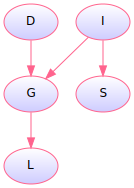

In [13]:
from src.utils.GraphvizUtil import *

pgmpyToGraph(model= model)

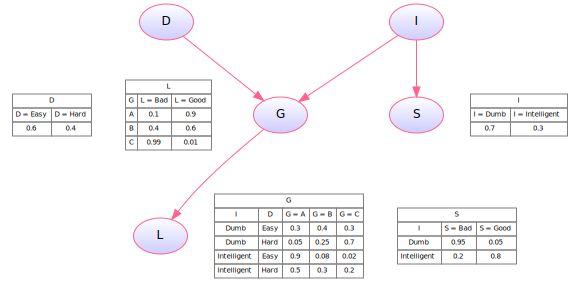

In [14]:
pgmpyToGraphCPD(model)

We can now call some methods on the `BayesianModel` object

In [15]:
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x7f687588ebd0>,
 <TabularCPD representing P(I:2) at 0x7f687588eb90>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x7f687588ec10>,
 <TabularCPD representing P(L:2 | G:3) at 0x7f687588ec50>,
 <TabularCPD representing P(S:2 | I:2) at 0x7f687588ec90>]

In [16]:
print('CPD with no state names: \n')
print(cpd_G)
print('\nCPD with state names: \n')
print(model.get_cpds('G'))

CPD with no state names: 

+------+------+------+------+------+
| I    | I(0) | I(0) | I(1) | I(1) |
+------+------+------+------+------+
| D    | D(0) | D(1) | D(0) | D(1) |
+------+------+------+------+------+
| G(0) | 0.3  | 0.05 | 0.9  | 0.5  |
+------+------+------+------+------+
| G(1) | 0.4  | 0.25 | 0.08 | 0.3  |
+------+------+------+------+------+
| G(2) | 0.3  | 0.7  | 0.02 | 0.2  |
+------+------+------+------+------+

CPD with state names: 

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+---------

In [17]:
model.get_cardinality('G')

3

## 2. Independencies in Bayesian Networks
Independencies implied by the network structure of a Bayesian network can be categorized as two types:

1. **Local Independencies:** Any variable in the network is independent of its non-descendants given its parents:
$$
( X \; \bot \; \text{NonDescendant}(X) \; | \; \text{Parent}(X) )
$$
where $\text{NonDescendant}(X)$ is the set of variables which are not descendants of $X$ and $\text{Parent}(X)$ is the set of variables which are parents of $X$.

2. **Global Independencies:** for discussing global independencies in bayesian networks we need to look at the various network structures possible. Starting with the case of $2$ nodes, there are only two possible ways for it to be connected

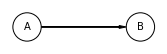

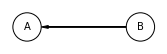

In [18]:
import matplotlib.pyplot as plt
import daft



graphAToB = daft.PGM()

graphAToB.add_node(daft.Node(name = 'A', content = r"A", x = 1, y = 1))
graphAToB.add_node(daft.Node(name = 'B', content = r"B", x = 3, y = 1))
graphAToB.add_edge(name1 = 'A', name2 = 'B')

graphAToB.render()

# -----
graphBToA = daft.PGM()

graphBToA.add_node(daft.Node(name = 'A', content = r"A", x = 1, y = 1))
graphBToA.add_node(daft.Node(name = 'B', content = r"B", x = 3, y = 1))
graphBToA.add_edge(name1 = 'B', name2 = 'A')

graphBToA.render()

plt.show()

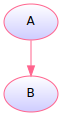

In [19]:
# Or render with graphviz to avoid having to specify x-y coordinates:
from src.utils.NetworkUtil import *
from src.utils.GraphvizUtil import *

pgmpyToGraph(model= convertDaftToPgmpy(pgm = graphAToB))

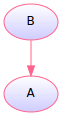

In [20]:
pgmpyToGraph(model= convertDaftToPgmpy(pgm = graphBToA))

Above it is obvious that any change of the node will affect the other node.

* For graph 1: if we take `Difficulty` $\rightarrow$ `Grade` and increase the difficulty then the probability of getting a higher grade decreases.
* For graph 2: if we take `SAT` $\leftarrow$ `Intelligence` and increase the probability of getting a good score on the SAT then that implies the student is intelligent, hence increasing the probability of the event `Intelligence := Intelligent`.

Therefore in both cases above any change in the variables lead to change in the other variable.

Note there are four possible ways of connection between any $3$ nodes:

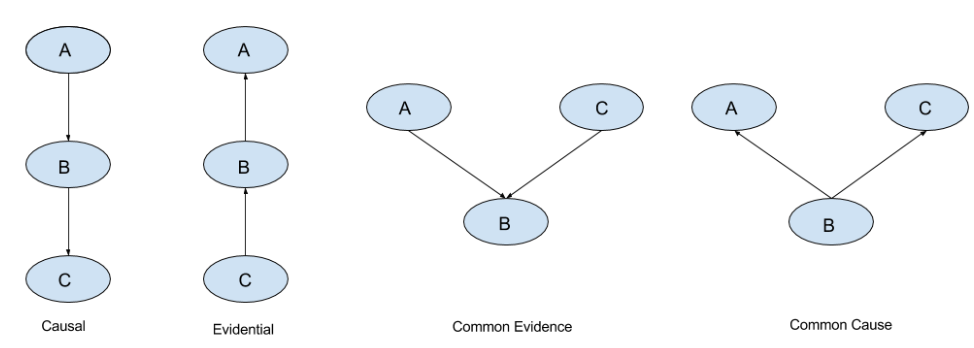

In [21]:
Image(filename = imagePath + 'fourConnections.png')

In [22]:
from src.utils.GraphvizUtil import *

causal: List[Tuple[Variable, Variable]] = [('A', 'B'), ('B', 'C')]
evidential: List[Tuple[Variable, Variable]] = [('C', 'B'), ('B', 'A')]
commonEvidence : List[Tuple[Variable, Variable]] = [('A', 'B'), ('C', 'B')]
commonCause: List[Tuple[Variable, Variable]] = [('B', 'A'), ('B', 'C')]

causalGraph = edgesToGraph(edges= causal)
evidentialGraph = edgesToGraph(edges= evidential)
commonEvidenceGraph = edgesToGraph(edges= commonEvidence)
commonCauseGraph = edgesToGraph(edges= commonCause)

# using later

Now in the above cases we will see the flow of influence from $A$ to $C$ under various cases:

1. **Causal:**
      * **General Case:** in the general case when we make changes to variable $A$, this will have an effect on variable $B$, and this change in $B$ will change the values in $C$.
      * **Other Case:** One other possible case is when $B$ is *observed* (means we know the value of $B$, so it is fixed). In this case, any change in $A$ won't affect $B$ since $B$'s value is already known. Then, there won't be any change in $C$ since it depends only on $B$. Mathematically, we can say that: $( A \; \bot \; C \; | \; B)$.
2. **Evidential:** Like in the **Causal** case, also observing $B$ renders $C$ independent of $A$. Otherwise when $B$ is not observed the influences flows from $A$ to $C$. Hence again $( A \; \bot \; C \; | \; B)$.
3. **Common Evidence:** This case is different from above. When $B$ is not observed (so when $B$ is not fixed in value)  any change in $A$ reflects some change in $B$ but not in $C$.
      * **Example 1:** Take the example of `Difficulty` $\rightarrow$ `Grade` $\leftarrow$ `Intelligence`. If we increase the `Difficulty` of the course, then the probability of getting a higher `Grade` falls but this has no effect on the `Intelligence` of the student.
      * **Example 2:** But when the node $B$ is observed (here `Grade` is observed, such as the student got a good grade, so the variable `Grade` is fixed), then if we increase the `Difficulty` of the course this will increase the probability of the student being `Intelligent` since we already know that he got a good `Grade`. Hence in thise case $(A \; \bot \; C)$ (so `Difficulty` and `Intelligence` are independent) and also $(A \; \bot \; C \; | \; B)$ (which means `Difficulty` and `Intelligence` are independent when conditional on `Grade`). This is known as the $V$ structure.
4. **Common Cause:** the influence flows from $A$ to $C$ when $B$ is not observed. ($\color{red}{\text{TODO: but by this structure's definition, influence can never flow from A to C}}$)

  $\color{red}{\text{TODO: not clear here}}$ But when $B$ is observed and ($\color{red}{\text{THEN??}}$) change in $A$ doesn't affect $C$ since it is only dependent on $B$. So here also $(A \; \bot \; C \; | \; B)$.

### Study: Independencies for Abstract Structure Types
Using the structures above, study how independencies are found:

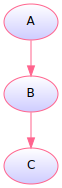

In [23]:

# TODO better document these types of model graphs using:
# ---> Korb book, page 40
# ---> pgmpy book (Ankur ankan), page 22
# ---> bayesialab book, page 336

# TODO better document the types of reasoning using:
# ---> Korb book, page 34
# ---> pgmpy book, page 21
# ---> bayesialab book, page 62



# TODO where to start: see page 338 in bayesialab for the kinds of reasonings that spring from the specific models.


causalGraph

In [24]:
causalModel = BayesianModel(causal)


# TODO newer pgmpy version: changes results!
#assert indepA == Independencies(['A', ['B', 'C']]), "Check: A is independent of B and C, at the same time"
assert causalModel.local_independencies(['A']) == Independencies()

#assert str(indepA) in localIndependencySynonyms(model = causalModel, queryNode='A')
#indepSynonymTable(model = causalModel, queryNode='A')

# TODO pgmpy change
assert causalModel.local_independencies('B') == Independencies()
#assert str(causalModel.local_independencies('B')) == '(B _|_ C | A)', 'Check: B is independent of C, given A (so event "B is independent of C" is conditional on A)'

assert str(causalModel.local_independencies('C')) == '(C _|_ A | B)', 'Check: C is independent of A when conditional on B'
assert causalModel.local_independencies('A') != causalModel.local_independencies('C'), 'Check: independencies of C is not the same as independencies of A, in causal model'


indepSynonymTable(causalModel, 'C')

             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(C _|_ A | B)     .....     (C _|_ A | B)


In [25]:
# TODO why wasn't A _|_C | B found when we queried the node A or B? what does this mean? global dependency? how is this calculated?
indeps = list(map(lambda x : str(x), causalModel.get_independencies().get_assertions()))
assert indeps == ['(A _|_ C | B)', '(C _|_ A | B)'], 'Check: overall independencies of causal model'

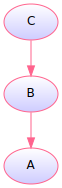

In [26]:
evidentialGraph

In [27]:
evidentialModel: BayesianModel = BayesianModel(evidential)

assert str(evidentialModel.local_independencies('A')) == '(A _|_ C | B)', 'Check: A is independent of C once conditional on B'

# TODO pgmpy version change
# assert str(evidentialModel.local_independencies('B')) == '(B _|_ A | C)', "Check: B is independent of A once conditional on C"


# TODO pgmpy version change
indepC: Independencies = evidentialModel.local_independencies('C')
#indepC # nothing TODO why?
#assert indepC == Independencies(['C', ['B','A']]), 'Check: C is independent of both B and A'
#assert str(indepC) in localIndependencySynonyms(model=evidentialModel, queryNode='C')


#indepSynonymTable(model = evidentialModel, queryNode ='C')
indepSynonymTable(model = evidentialModel, queryNode ='A')

             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(A _|_ C | B)     .....     (A _|_ C | B)


In [28]:
# Continued on evidential model
indeps = list(map(lambda x : str(x), evidentialModel.get_independencies().get_assertions()))
assert indeps == ['(C _|_ A | B)', '(A _|_ C | B)'], 'Check: overall independencies of evidential model'

TODO: use this book by Korb (Bayesian Artificial Intelligence) to explain the intuitions behind all these four types of models: [example intuition for common evidence model, says it is INVERSE of common cause model!](https://hyp.is/TBnOeo5AEeqyTPtnV0yx1w/bayesian-intelligence.com/publications/bai/book/BAI_Chapter2.pdf)

TODO: also use the pgmpy book [https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781784394684/1/ch01lvl1sec14/bayesian-models](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781784394684/1/ch01lvl1sec14/bayesian-models) which has more complete explanations

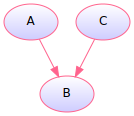

In [29]:
commonEvidenceGraph

In [30]:
commonEvidenceModel = BayesianModel(commonEvidence)

assert commonEvidenceModel.local_independencies('B') == Independencies() # no independency for B TODO why?? Couldn't we say that B is independent of  (A and C) GIVEN (A and C)?


indepA: Independencies = commonEvidenceModel.local_independencies('A')
assert indepA == Independencies(['A', ['C']]), 'Check: A is independent of C'
assert str(indepA) in localIndependencySynonyms(model=commonEvidenceModel, queryNode='A')
assert str(indepA) == '(A _|_ C)'


indepC: Independencies = commonEvidenceModel.local_independencies('C'); indepC
assert indepC == Independencies(['C',['A']]), 'Check: C is independent of both B and A'
assert str(indepC) in localIndependencySynonyms(model=commonEvidenceModel, queryNode='C')
assert str(indepC) == '(C _|_ A)'

indeps = list(map(lambda x : str(x), commonEvidenceModel.get_independencies().get_assertions()))
assert indeps == ['(A _|_ C)', '(C _|_ A)'], 'Check: overall independencies of common evidence model (A and C should be independent of each other)'

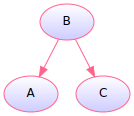

In [31]:
commonCauseGraph

In [32]:
commonCauseModel = BayesianModel(commonCause)

assert str(commonCauseModel.local_independencies('A')) == '(A _|_ C | B)', 'Check: A and C are independent once conditional on B'


assert str(commonCauseModel.local_independencies('C')) == '(C _|_ A | B)', 'Check: A and C are independent once conditional on B (when B is fixed / observed)'
# assert Independencies(['A', 'C', ['B']]) == Independencies(['C', 'A', ['B']])

indepB: Independencies = commonCauseModel.local_independencies('B'); indepB
# TODO pgmpy change
assert indepB == Independencies()
#assert indepB == Independencies(['B', ['A', 'C']]), "Check: B is independent of C AND A at the same time"
# assert str(indepB) in localIndependencySynonyms(model=commonCauseModel, queryNode='B')

#indepSynonymTable(model = commonCauseModel, queryNode ='B')


indeps = list(map(lambda x : str(x), commonCauseModel.get_independencies().get_assertions()))
assert indeps == ['(A _|_ C | B)', '(C _|_ A | B)'], 'Check: overall independencies of common cause model'

### Study: Individual, Local Independencies for Grade Example
Using the example Grade structure, find the **individual** local independencies:

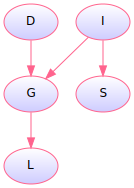

In [33]:
pgmpyToGraph(model= model)

In [34]:
indepD: Independencies = model.local_independencies('D'); indepD

# TODO pgmpy change
# assert indepD == Independencies(['D', ['G', 'S', 'I', 'L']]), 'Check: D is independent of all G, S, I, and L'
assert indepD == Independencies(['D', ['S', 'I']]), 'Check: D is independent of all S, I'
assert str(indepD) in localIndependencySynonyms(model = model, queryNode ='D'), 'Check: D is independent of S, I'

indepSynonymTable(model, 'D')

             INDEPENDENCIES TABLE             
Fancy Notation      .....     Regular Notation
----------------------------------------------
(D _|_ {S ∩ I})     .....     (D _|_ S, I)
(D _|_ {I ∩ S})     .....     (D _|_ I, S)


In [35]:
indepI: Independencies = model.local_independencies('I'); indepI

# TODO pgmpy change
# assert indepI == Independencies(['I', ['G', 'S', 'L','D']]), 'Check: I is independent of all {G,S,L,D}'
assert indepI == Independencies(['I', ['D']])
assert str(indepI) in localIndependencySynonyms(model=model, queryNode='I')
assert str(indepI) == '(I _|_ D)'

In [36]:
indepG: Independencies = model.local_independencies('G'); indepG

# TODO pgmpy change
#assert indepG == Independencies(['G', ['S', 'L'], ['I','D']]), 'Check: G is independent of (L, and S) given (I, and D)'
assert indepG == Independencies(['G', ['S'], ['D', 'I']])
assert str(indepG) in localIndependencySynonyms(model=model, queryNode='G')

indepSynonymTable(model = model, queryNode ='G')

               INDEPENDENCIES TABLE               
Fancy Notation          .....     Regular Notation
--------------------------------------------------
(G _|_ S | {I ∩ D})     .....     (G _|_ S | I, D)
(G _|_ S | {D ∩ I})     .....     (G _|_ S | D, I)


In [37]:
indepS: Independencies = model.local_independencies('S'); indepS

assert indepS == Independencies(['S', ['D', 'G', 'L'], 'I']), 'Check: S is independent of {D,G,L} given I'
assert str(indepS) in localIndependencySynonyms(model=model, queryNode='S')

indepSynonymTable(model = model,queryNode='S')

                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(S _|_ {G ∩ L ∩ D} | I)     .....     (S _|_ G, L, D | I)
(S _|_ {G ∩ D ∩ L} | I)     .....     (S _|_ G, D, L | I)
(S _|_ {L ∩ G ∩ D} | I)     .....     (S _|_ L, G, D | I)
(S _|_ {L ∩ D ∩ G} | I)     .....     (S _|_ L, D, G | I)
(S _|_ {D ∩ G ∩ L} | I)     .....     (S _|_ D, G, L | I)
(S _|_ {D ∩ L ∩ G} | I)     .....     (S _|_ D, L, G | I)


In [38]:
indepL: Independencies = model.local_independencies('L'); indepL

assert indepL == Independencies(['L', ['S','I','D'], 'G']), 'Check: L is independent of {S,I,D} given G'
assert str(indepL) in localIndependencySynonyms(model=model, queryNode='L')

indepSynonymTable(model = model,queryNode='L')

                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(L _|_ {D ∩ S ∩ I} | G)     .....     (L _|_ D, S, I | G)
(L _|_ {D ∩ I ∩ S} | G)     .....     (L _|_ D, I, S | G)
(L _|_ {S ∩ D ∩ I} | G)     .....     (L _|_ S, D, I | G)
(L _|_ {S ∩ I ∩ D} | G)     .....     (L _|_ S, I, D | G)
(L _|_ {I ∩ D ∩ S} | G)     .....     (L _|_ I, D, S | G)
(L _|_ {I ∩ S ∩ D} | G)     .....     (L _|_ I, S, D | G)


### Study: Multiple Local Independencies for Grade Example
Using the example Grade structure, find the **n-way** local independencies: (they are just concatenations of the individual independencies)

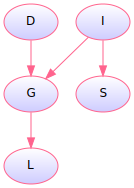

In [39]:
pgmpyToGraph(model)

In [40]:
indep_DS: Independencies = model.local_independencies(['D','S']).get_assertions()
indep_D = model.local_independencies('D').get_assertions()
indep_S = model.local_independencies('S').get_assertions()

assert indep_DS == indep_D + indep_S, 'Check: independencies of two nodes (D, S) equals independencies of the separate nodes, concatenated together'

# -------
indep_GL: Independencies = model.local_independencies(['G','L']).get_assertions()
indep_G = model.local_independencies('G').get_assertions()
indep_L = model.local_independencies('L').get_assertions()

assert indep_GL == indep_G + indep_L, 'Check: independencies of two nodes (G, L) equals independencies of the separate nodes, concatenated together'


# -------
indep_all: Independencies = model.local_independencies(['G','I', 'D', 'S','L']).get_assertions()
indep_G = model.local_independencies('G').get_assertions()
indep_L = model.local_independencies('L').get_assertions()
indep_D = model.local_independencies('D').get_assertions()
indep_S = model.local_independencies('S').get_assertions()
indep_I = model.local_independencies('I').get_assertions()

assert set(indep_all) == set(indep_G + indep_L + indep_D + indep_S + indep_I), 'Check: independencies of all nodes (D, S, I, G, L) equals independencies of the separate nodes, concatenated together'

indep_all



[(G _|_ S | I, D),
 (I _|_ D),
 (D _|_ S, I),
 (S _|_ G, L, D | I),
 (L _|_ D, S, I | G)]

### Study: Active Trails
**Definition: Active Trail:** For any two variables $A$ and $B$ in a network, if any change in $A$ influences the values of $B$ then there is an active trail between $A$ and $B$.

The function `active_trail_nodes` in pgmpy gives a set of nodes which are affected (correlated) by any change in the node passed in the argument. The return value is `{keyNode : trailSetNodes}`, where the key value in the dictionary is the node that is changed, and the set in the value of the dictionary is the set of (trail) nodes that are affected by the change in the key node. (`{changerNode : affectedNodes}`)

* NOTE: exact description from documentation: Returns a dictionary with the given variables as keys (of the dict) and all the nodes reachable from that respective variable as values (of the dict). This means the active trails are: `changerNode ---> affectedNodes[0], changerNode ---> affectedNodes[1], ... changerNode ---> affectedNodes[LEN-1]`, ... etc

* NOTE: studying active trails from a purely combinatorial point of view, for each type of model (no intuition yet,
that is below when we combine independencies + active trails + types of reasoning per model)


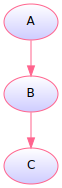

In [41]:
causalGraph

In [42]:

# Testing 0: null check

assert causalModel.active_trail_nodes('A', observed = 'A') == {'A': set()}, 'Null Check: changing A and keeping A fixed results in NO change to any node'

# ---------------------------------------------------------------------------------------------------------

# Testing 1: changing individual nodes, keeping no other nodes fixed

assert causalModel.active_trail_nodes('A') == {'A': {'A', 'B', 'C'}}, "Check: Changing node A results in changes of values of the nodes A, B, C"
assert causalModel.active_trail_nodes('B') == {'B': {'A', 'B', 'C'}}, "Check: Changing node B results in changes of values of the nodes A, B, C"
assert causalModel.active_trail_nodes('C') == {'C': {'A', 'B', 'C'}}, "Check: Changing node C results in changes of values of the nodes A, B, C"

# ---------------------------------------------------------------------------------------------------------

# Testing 2: changing individual nodes (two-node case extrapolated to the n-node case)

assert causalModel.active_trail_nodes(['A','C']) == {'A': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}, "Check: querying for active trail nodes of two query nodes results in the dictionary concatenated from each separate query"


# ---------------------------------------------------------------------------------------------------------

# Testing 3a: changing node A, keeping other variables FIXED

assert causalModel.active_trail_nodes('A', observed = 'B') == {'A': {'A'}}, "Check: Changing A and keeping B fixed results in change JUST to node A (not even to C, which is fed from B)"
assert causalModel.active_trail_nodes('A', observed = 'C') == {'A': {'A', 'B'}}, "Check: Changing A and keeping C fixed results in changes of nodes A and B"
assert causalModel.active_trail_nodes('A', observed = ['B','C']) == {'A': {'A'}}, "Check: Changing A and keeping both B, C fixed results in change JUST to A"


# Testing 3b: changing node B, keeping other variables FIXED

assert causalModel.active_trail_nodes('B', observed = 'A') == {'B': {'B', 'C'}}, "Check: Changing B and keeping A fixed results in changes just to B, C"
# TODO why is this so? THis is strange
assert causalModel.active_trail_nodes('B', observed = 'C') == {'B': {'A', 'B'}}, "Check: Changing B and keeping C fixed results in changes just to A and B"
assert causalModel.active_trail_nodes('B', observed = ['A','C']) == {'B': {'B'}}, "Check: Changing B and keeping A, C fixed changes just B"


# Testing 3c: changing node C, keeping other variables FIXED

assert causalModel.active_trail_nodes('C', observed = 'A') == {'C': {'B', 'C'}}, "Check: Changing C and keeping A fixed results in changes just to C and B"
assert causalModel.active_trail_nodes('C', observed = 'B') == {'C': {'C'}}, "Check: Changing C and keeping B fixed results in change JUST to C"
# NOTE on above: when changing C and keeping its neighbor fixed, that neighbor acts as interruptor so A cannot be changed. When changing C and keeping the other node (A) fixed, the neighbor (B) still gets the ripple change.
assert causalModel.active_trail_nodes('C', observed = ['A','B']) == {'C': {'C'}}, "Check: Changing C and keeping both A, B fixed results in changing just C"


# ---------------------------------------------------------------------------------------------------------

# PREPARATION for testing 4

assert causalModel.active_trail_nodes(['A','B', 'C']) == {'A': {'A', 'B', 'C'}, 'B': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}


a_a = causalModel.active_trail_nodes('A', observed ='A'); a_a
b_a = causalModel.active_trail_nodes('B', observed ='A'); b_a
c_a = causalModel.active_trail_nodes('C', observed ='A'); c_a
all_a = causalModel.active_trail_nodes(['A','B','C'], observed = 'A'); all_a
# The first way to do this above test:
assert list(all_a.items()) == list(a_a.items()) + list(b_a.items()) + list(c_a.items())
# The second way to do the above test:
assert all_a == {'A': set(), 'B': {'B', 'C'}, 'C': {'B', 'C'}}


a_b = causalModel.active_trail_nodes('A', observed ='B'); a_b
b_b = causalModel.active_trail_nodes('B', observed ='B'); b_b
c_b = causalModel.active_trail_nodes('C', observed ='B'); c_b
all_b = causalModel.active_trail_nodes(['A','B','C'], observed = 'B'); all_b
# The first way to do the above test
assert list(all_b.items()) == list(a_b.items()) + list(b_b.items()) + list(c_b.items())
# The second way
assert all_b == {'A': {'A'}, 'B': set(), 'C': {'C'}}


a_c = causalModel.active_trail_nodes('A', observed ='C'); a_c
b_c = causalModel.active_trail_nodes('B', observed ='C'); b_c
c_c = causalModel.active_trail_nodes('C', observed ='C'); c_c
all_c = causalModel.active_trail_nodes(['A','B','C'], observed = 'C'); all_c
# The first way to do the above test
assert list(all_c.items()) == list(a_c.items()) + list(b_c.items()) + list(c_c.items())
# The second way
assert all_c == {'A': {'A', 'B'}, 'B': {'A', 'B'}, 'C': set()}



# Testing 4: changing all nodes, keeping combination of other variables FIXED
# Moral of the story (general rule going on here): passing the list of variables gives a result that is the concatenation of the results from nodes passing in individually (assuming ONE observed variable, because when more than ONE observed variable, this rule doesn't hold, see case ['A','B'] below)

from src.utils.GenericUtil import intersectDictValues

assert causalModel.active_trail_nodes(['A','B','C'], observed = ['A', 'B']) \
       == intersectDictValues(all_a, all_b) \
       == {'A': set(), 'B': set(), 'C': {'C'}}

assert causalModel.active_trail_nodes(['A','B','C'], observed = ['A', 'C']) \
       == intersectDictValues(all_a, all_c) \
       == {'A': set(), 'B': {'B'}, 'C': set()}

assert causalModel.active_trail_nodes(['A','B','C'], observed = ['B', 'C']) \
       == intersectDictValues(all_c, all_b) \
       == {'A': {'A'}, 'B': set(), 'C': set()}








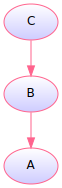

In [43]:
evidentialGraph

In [44]:

# Testing 0: null check
assert evidentialModel.active_trail_nodes('A', observed = 'A') == {'A': set()}, 'Null Check: changing A and keeping A fixed results in NO change to any node'

# ---------------------------------------------------------------------------------------------------------

# Testing 1: changing individual nodes, keeping no other nodes fixed

assert evidentialModel.active_trail_nodes('A') == {'A': {'A', 'B', 'C'}}, "Check: Changing node A results in changes of values of the nodes A, B, C"
assert evidentialModel.active_trail_nodes('B') == {'B': {'A', 'B', 'C'}}, "Check: Changing node B results in changes of values of the nodes A, B, C"
assert evidentialModel.active_trail_nodes('C') == {'C': {'A', 'B', 'C'}}, "Check: Changing node C results in changes of values of the nodes A, B, C"

# ---------------------------------------------------------------------------------------------------------

# Testing 2: changing individual nodes (two-node case extrapolated to the n-node case)
assert evidentialModel.active_trail_nodes(['A','C']) == {'A': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}, "Check: querying for active trail nodes of two query nodes results in the dictionary concatenated from each separate query"


# ---------------------------------------------------------------------------------------------------------
# Testing 3a: changing node A, keeping other variables FIXED

assert evidentialModel.active_trail_nodes('A', observed = 'B') == {'A': {'A'}}, "Check: Changing A and keeping B fixed results in change JUST to node A (not even to C, which is fed from B)"
assert evidentialModel.active_trail_nodes('A', observed = 'C') == {'A': {'A', 'B'}}, "Check: Changing A and keeping C fixed results in changes of nodes A and B"
assert evidentialModel.active_trail_nodes('A', observed = ['B','C']) == {'A': {'A'}}, "Check: Changing A and keeping both B, C fixed results in change JUST to A"

# Testing 3b: changing node B, keeping other variables FIXED

assert evidentialModel.active_trail_nodes('B', observed = 'A') == {'B': {'B', 'C'}}, "Check: Changing B and keeping A fixed results in changes just to B, C"
# TODO why is this so? THis is strange
assert evidentialModel.active_trail_nodes('B', observed = 'C') == {'B': {'A', 'B'}}, "Check: Changing B and keeping C fixed results in changes just to A and B"
assert evidentialModel.active_trail_nodes('B', observed = ['A','C']) == {'B': {'B'}}, "Check: Changing B and keeping A, C fixed changes just B"


# Testing 3c: changing node C, keeping other variables FIXED

assert evidentialModel.active_trail_nodes('C', observed = 'A') == {'C': {'B', 'C'}}, "Check: Changing C and keeping A fixed results in changes just to C and B"
assert evidentialModel.active_trail_nodes('C', observed = 'B') == {'C': {'C'}}, "Check: Changing C and keeping B fixed results in change JUST to C"
# NOTE on above: when changing C and keeping its neighbor fixed, that neighbor acts as interruptor so A cannot be changed. When changing C and keeping the other node (A) fixed, the neighbor (B) still gets the ripple change.
assert evidentialModel.active_trail_nodes('C', observed = ['A','B']) == {'C': {'C'}}, "Check: Changing C and keeping both A, B fixed results in changing just C"

# ---------------------------------------------------------------------------------------------------------

# PREPARATION for testing 4

assert evidentialModel.active_trail_nodes(['A','B', 'C']) == {'A': {'A', 'B', 'C'}, 'B': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}


a_a = evidentialModel.active_trail_nodes('A', observed ='A'); a_a
b_a = evidentialModel.active_trail_nodes('B', observed ='A'); b_a
c_a = evidentialModel.active_trail_nodes('C', observed ='A'); c_a
all_a = evidentialModel.active_trail_nodes(['A','B','C'], observed = 'A'); all_a
# The first way to do this above test:
assert list(all_a.items()) == list(a_a.items()) + list(b_a.items()) + list(c_a.items())
# The second way to do the above test:
assert all_a == {'A': set(), 'B': {'B', 'C'}, 'C': {'B', 'C'}}, "Check: changing A, B, C and keeping A fixed results in changes just to B, C (just active trail nodes from B -> B, B -> C, C -> C, C -> B)"


a_b = evidentialModel.active_trail_nodes('A', observed ='B'); a_b
b_b = evidentialModel.active_trail_nodes('B', observed ='B'); b_b
c_b = evidentialModel.active_trail_nodes('C', observed ='B'); c_b
all_b = evidentialModel.active_trail_nodes(['A','B','C'], observed = 'B'); all_b
# The first way to do the above test
assert list(all_b.items()) == list(a_b.items()) + list(b_b.items()) + list(c_b.items())
# The second way
assert all_b == {'A': {'A'}, 'B': set(), 'C': {'C'}}


a_c = evidentialModel.active_trail_nodes('A', observed ='C'); a_c
b_c = evidentialModel.active_trail_nodes('B', observed ='C'); b_c
c_c = evidentialModel.active_trail_nodes('C', observed ='C'); c_c
all_c = evidentialModel.active_trail_nodes(['A','B','C'], observed = 'C'); all_c
# The first way to do the above test
assert list(all_c.items()) == list(a_c.items()) + list(b_c.items()) + list(c_c.items())
# The second way
assert all_c == {'A': {'A', 'B'}, 'B': {'A', 'B'}, 'C': set()}



# Testing 4: changing all nodes, keeping combination of other variables FIXED
# Moral of the story (general rule going on here): passing the list of variables gives a result that is the concatenation of the results from nodes passing in individually (assuming ONE observed variable, because when more than ONE observed variable, this rule doesn't hold, see case ['A','B'] below)

from src.utils.GenericUtil import intersectDictValues

assert evidentialModel.active_trail_nodes(['A','B','C'], observed = ['A', 'B']) \
       == intersectDictValues(all_a, all_b) \
       == {'A': set(), 'B': set(), 'C': {'C'}}

assert evidentialModel.active_trail_nodes(['A','B','C'], observed = ['A', 'C']) \
       == intersectDictValues(all_a, all_c) \
       == {'A': set(), 'B': {'B'}, 'C': set()}

assert evidentialModel.active_trail_nodes(['A','B','C'], observed = ['B', 'C']) \
       == intersectDictValues(all_c, all_b) \
       == {'A': {'A'}, 'B': set(), 'C': set()}







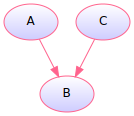

In [45]:
commonEvidenceGraph

In [46]:
# Testing 0: null check

assert commonEvidenceModel.active_trail_nodes('A', observed = 'A') == {'A': set()}, 'Null Check: changing A and keeping A fixed results in NO change to any node'

# ---------------------------------------------------------------------------------------------------------


# Testing 1: individual nodes

assert commonEvidenceModel.active_trail_nodes('A') == {'A': {'A', 'B'}}, "Check: Changing ndoe A results in changes just to A and B, not to C (since C is connected to B downward, and never to A)"
assert commonEvidenceModel.active_trail_nodes('B') == {'B': {'A', 'B', 'C'}}, "Check: Changing node B results in changes of values of the nodes A, B, C"
assert commonEvidenceModel.active_trail_nodes('C') == {'C': {'B', 'C'}}, "Check: changing node C results in changes to values of ndoes B, and C, not to A (since A is never connected to C, just to B downward)"

# ---------------------------------------------------------------------------------------------------------

# Testing 2: changing individual nodes (two-node case extrapolated to the n-node case)

assert commonEvidenceModel.active_trail_nodes(['A','C']) == {'A': {'A', 'B'}, 'C': {'B', 'C'}}, "Check: querying for active trail nodes of two query nodes results in the dictionary concatenated from each separate query"

# ---------------------------------------------------------------------------------------------------------

# Testing 3a: changing node A, keeping other variables FIXED

assert commonEvidenceModel.active_trail_nodes('A', observed = 'B') == {'A': {'A', 'C'}}, "Check: Changing A and keeping B fixed results in change A and C"
assert commonEvidenceModel.active_trail_nodes('A', observed = 'C') == {'A': {'A', 'B'}}, "Check: Changing A and keeping C fixed results in changes of nodes A and B"
assert commonEvidenceModel.active_trail_nodes('A', observed = ['B','C']) == {'A': {'A'}}, "Check: Changing A and keeping both B, C fixed results in change JUST to A"


# Testing 3b: changing node B, keeping other variables FIXED

assert commonEvidenceModel.active_trail_nodes('B', observed = 'A') == {'B': {'B', 'C'}}, "Check: Changing B and keeping A fixed results in changes just to B, C"
# TODO why is this so? THis is strange
assert commonEvidenceModel.active_trail_nodes('B', observed = 'C') == {'B': {'A', 'B'}}, "Check: Changing B and keeping C fixed results in changes just to A and B"
assert commonEvidenceModel.active_trail_nodes('B', observed = ['A','C']) == {'B': {'B'}}, "Check: Changing B and keeping A, C fixed changes just B"


# Testing 3c: changing node C, keeping other variables FIXED

assert commonEvidenceModel.active_trail_nodes('C', observed = 'A') == {'C': {'B', 'C'}}, "Check: Changing C and keeping A fixed results in changes just to C and B"
assert commonEvidenceModel.active_trail_nodes('C', observed = 'B') == {'C': {'A', 'C'}}, "Check: Changing C and keeping B fixed results in change to both A, C" # TODO why this is strange??
# NOTE on above: when changing C and keeping its neighbor (B) fixed, that neighbor DOES NOT act as interruptor so A still gets changed (unlike in causal and evidence models). But when changing C and keeping the other node (A) fixed, the neighbor (B) is allowed to receive the ripple change.
assert commonEvidenceModel.active_trail_nodes('C', observed = ['A','B']) == {'C': {'C'}}, "Check: Changing C and keeping both A, B fixed results in changing just C"


# ---------------------------------------------------------------------------------------------------------

# PREPARATION for testing 4

assert commonEvidenceModel.active_trail_nodes(['A','B', 'C']) == {'A': {'A', 'B'}, 'B': {'A', 'B', 'C'}, 'C': {'B', 'C'}}


a_a = commonEvidenceModel.active_trail_nodes('A', observed ='A'); a_a
b_a = commonEvidenceModel.active_trail_nodes('B', observed ='A'); b_a
c_a = commonEvidenceModel.active_trail_nodes('C', observed ='A'); c_a
all_a = commonEvidenceModel.active_trail_nodes(['A','B','C'], observed = 'A'); all_a
# The first way to do this above test:
assert list(all_a.items()) == list(a_a.items()) + list(b_a.items()) + list(c_a.items())
# The second way to do the above test:
assert all_a == {'A': set(), 'B': {'B', 'C'}, 'C': {'B', 'C'}}, "Check 1: changing A, B, C and keeping A fixed results in changes just to B, C (just active trail nodes from B -> B, B -> C, C -> C, C -> B)"


a_b = commonEvidenceModel.active_trail_nodes('A', observed ='B'); a_b
b_b = commonEvidenceModel.active_trail_nodes('B', observed ='B'); b_b
c_b = commonEvidenceModel.active_trail_nodes('C', observed ='B'); c_b
all_b = commonEvidenceModel.active_trail_nodes(['A','B','C'], observed = 'B'); all_b
# The first way to do the above test
assert list(all_b.items()) == list(a_b.items()) + list(b_b.items()) + list(c_b.items())
# The second way
assert all_b  == {'A': {'A', 'C'}, 'B': set(), 'C': {'A', 'C'}}


a_c = commonEvidenceModel.active_trail_nodes('A', observed ='C'); a_c
b_c = commonEvidenceModel.active_trail_nodes('B', observed ='C'); b_c
c_c = commonEvidenceModel.active_trail_nodes('C', observed ='C'); c_c
all_c = commonEvidenceModel.active_trail_nodes(['A','B','C'], observed = 'C'); all_c
# The first way to do the above test
assert list(all_c.items()) == list(a_c.items()) + list(b_c.items()) + list(c_c.items())
# The second way
assert all_c == {'A': {'A', 'B'}, 'B': {'A', 'B'}, 'C': set()}


# Testing 4: changing all nodes, keeping combination of other variables FIXED
# Moral of the story (general rule going on here): passing the list of variables gives a result that is the concatenation of the results from nodes passing in individually (assuming ONE observed variable, because when more than ONE observed variable, this rule doesn't hold, see case ['A','B'] below)

from src.utils.GenericUtil import intersectDictValues

assert commonEvidenceModel.active_trail_nodes(['A','B','C'], observed = ['A', 'B']) \
       == intersectDictValues(all_a, all_b) \
       == {'A': set(), 'B': set(), 'C': {'C'}}

assert commonEvidenceModel.active_trail_nodes(['A','B','C'], observed = ['A', 'C']) \
       == intersectDictValues(all_a, all_c) \
       == {'A': set(), 'B': {'B'}, 'C': set()}

assert commonEvidenceModel.active_trail_nodes(['A','B','C'], observed = ['B', 'C']) \
       == intersectDictValues(all_c, all_b) \
       == {'A': {'A'}, 'B': set(), 'C': set()}




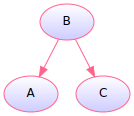

In [47]:
commonCauseGraph

In [48]:
# Testing 0: null check

assert commonCauseModel.active_trail_nodes('A', observed = 'A') == {'A': set()}, 'Null Check: changing A and keeping A fixed results in NO change to any node'

# ---------------------------------------------------------------------------------------------------------


# Testing 1: individual nodes

assert commonCauseModel.active_trail_nodes('A') == {'A': {'A', 'B', 'C'}}, "Check: Changing ndoe A results in changes to all A, B, C nodes"
assert commonCauseModel.active_trail_nodes('B') == {'B': {'A', 'B', 'C'}}, "Check: Changing node B results in changes of values of the nodes A, B, C"
assert commonCauseModel.active_trail_nodes('C') == {'C': {'A', 'B', 'C'}}, "Check: changing node C results in changes to values of all A, B, C nodes"

# ---------------------------------------------------------------------------------------------------------

# Testing 2: changing individual nodes (two-node case extrapolated to the n-node case)

assert commonCauseModel.active_trail_nodes(['A','C']) == {'A': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}, "Check: querying for active trail nodes of two query nodes results in the dictionary concatenated from each separate query"

# ---------------------------------------------------------------------------------------------------------

# Testing 3a: changing node A, keeping other variables FIXED

assert commonCauseModel.active_trail_nodes('A', observed = 'B') == {'A': {'A'}}, "Check: Changing A and keeping B fixed results in change just A"
assert commonCauseModel.active_trail_nodes('A', observed = 'C') == {'A': {'A', 'B'}}, "Check: Changing A and keeping C fixed results in changes of nodes A and B"
assert commonCauseModel.active_trail_nodes('A', observed = ['B','C']) == {'A': {'A'}}, "Check: Changing A and keeping both B, C fixed results in change JUST to A"


# Testing 3b: changing node B, keeping other variables FIXED

assert commonCauseModel.active_trail_nodes('B', observed = 'A') == {'B': {'B', 'C'}}, "Check: Changing B and keeping A fixed results in changes just to B, C"
# TODO why is this so? THis is strange
assert commonCauseModel.active_trail_nodes('B', observed = 'C') == {'B': {'A', 'B'}}, "Check: Changing B and keeping C fixed results in changes just to A and B"
assert commonCauseModel.active_trail_nodes('B', observed = ['A','C']) == {'B': {'B'}}, "Check: Changing B and keeping A, C fixed changes just B"


# Testing 3c: changing node C, keeping other variables FIXED

assert commonCauseModel.active_trail_nodes('C', observed = 'A') == {'C': {'B', 'C'}}, "Check: Changing C and keeping A fixed results in changes just to C and B"
assert commonCauseModel.active_trail_nodes('C', observed = 'B') == {'C': {'C'}}, "Check: Changing C and keeping B fixed results in change to both A, C" # TODO why this is strange??
# NOTE on above: when changing C and keeping its neighbor (B) fixed, that neighbor DOES NOT act as interruptor so A still gets changed (unlike in causal and evidence models). But when changing C and keeping the other node (A) fixed, the neighbor (B) is allowed to receive the ripple change.
assert commonCauseModel.active_trail_nodes('C', observed = ['A','B']) == {'C': {'C'}}, "Check: Changing C and keeping both A, B fixed results in changing just C"


# ---------------------------------------------------------------------------------------------------------

# PREPARATION for testing 4

assert commonCauseModel.active_trail_nodes(['A','B', 'C']) == {'A': {'A', 'B', 'C'}, 'B': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}


a_a = commonCauseModel.active_trail_nodes('A', observed ='A'); a_a
b_a = commonCauseModel.active_trail_nodes('B', observed ='A'); b_a
c_a = commonCauseModel.active_trail_nodes('C', observed ='A'); c_a
all_a = commonCauseModel.active_trail_nodes(['A','B','C'], observed = 'A'); all_a
# The first way to do this above test:
assert list(all_a.items()) == list(a_a.items()) + list(b_a.items()) + list(c_a.items())
# The second way to do the above test:
assert all_a == {'A': set(), 'B': {'B', 'C'}, 'C': {'B', 'C'}}, "Check 1: changing A, B, C and keeping A fixed results in changes just to B, C (just active trail nodes from B -> B, B -> C, C -> C, C -> B)"


a_b = commonCauseModel.active_trail_nodes('A', observed ='B'); a_b
b_b = commonCauseModel.active_trail_nodes('B', observed ='B'); b_b
c_b = commonCauseModel.active_trail_nodes('C', observed ='B'); c_b
all_b = commonCauseModel.active_trail_nodes(['A','B','C'], observed = 'B'); all_b
# The first way to do the above test
assert list(all_b.items()) == list(a_b.items()) + list(b_b.items()) + list(c_b.items())
# The second way
assert all_b  == {'A': {'A'}, 'B': set(), 'C': {'C'}}


a_c = commonCauseModel.active_trail_nodes('A', observed ='C'); a_c
b_c = commonCauseModel.active_trail_nodes('B', observed ='C'); b_c
c_c = commonCauseModel.active_trail_nodes('C', observed ='C'); c_c
all_c = commonCauseModel.active_trail_nodes(['A','B','C'], observed = 'C'); all_c
# The first way to do the above test
assert list(all_c.items()) == list(a_c.items()) + list(b_c.items()) + list(c_c.items())
# The second way
assert all_c == {'A': {'A', 'B'}, 'B': {'A', 'B'}, 'C': set()}


# Testing 4: changing all nodes, keeping combination of other variables FIXED
# Moral of the story (general rule going on here): passing the list of variables gives a result that is the concatenation of the results from nodes passing in individually (assuming ONE observed variable, because when more than ONE observed variable, this rule doesn't hold, see case ['A','B'] below)

from src.utils.GenericUtil import intersectDictValues

assert commonCauseModel.active_trail_nodes(['A','B','C'], observed = ['A', 'B']) \
       == intersectDictValues(all_a, all_b) \
       == {'A': set(), 'B': set(), 'C': {'C'}}

assert commonCauseModel.active_trail_nodes(['A','B','C'], observed = ['A', 'C']) \
       == intersectDictValues(all_a, all_c) \
       == {'A': set(), 'B': {'B'}, 'C': set()}

assert commonCauseModel.active_trail_nodes(['A','B','C'], observed = ['B', 'C']) \
       == intersectDictValues(all_c, all_b) \
       == {'A': {'A'}, 'B': set(), 'C': set()}







### Study: Types of Reasonings As Active Trails for the Four Abstract Models

Understanding how conditioning on different variables for different kinds of models creates active trails, thus enabling different kinds of reasoning types.

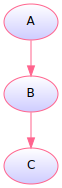

In [49]:
causalGraph

$\color{MediumVioletRed}{\text{Case 1: Marginal Dependence}}$

$$
\color{Green}{ B \; \text{is unknown: }\;\;\;\;\;\;\;\;\;\;\; A \longrightarrow B \longrightarrow C}
$$

When the middle node $B$ is unknown / unobserved, there IS an active trail between $A$ and $C$. In other words, there is a dependence between $A$ and $C$ when $B$ is unobserved. This means the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.

In [50]:
# TESTING: active trail method
assert causalModel.is_active_trail(start = 'A', end = 'C', observed = None)

assert causalModel.active_trail_nodes(variables = ['A', 'C']) == {'A': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}

showActiveTrails(model = causalModel, variables = ['A', 'C'])

A --> C
A --> B
A --> A
C --> C
C --> B
C --> A


$\color{MediumVioletRed}{\text{Case 2: Conditional Independence}}$

$$
\color{DeepSkyBlue}{ B \; \text{is fixed: }\;\;\;\;\;\;\;\;\;\;\; A \; \bot \; C \; | \; B}
$$

When the middle node $B$ is known (fixed / observed), then there is NO active trail between $A$ and $C$. In other words, $A$ and $C$ are locally independent when $B$'s state is observed. This means the probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

In [51]:
# TESTING: active trail method
assert not causalModel.is_active_trail(start = 'A', end = 'C', observed = 'B')

assert causalModel.active_trail_nodes(variables = ['A', 'C'], observed = 'B') == {'A': {'A'}, 'C': {'C'}}

showActiveTrails(model = causalModel, variables = ['A', 'C'], observed = 'B')

A --> A
C --> C


In [52]:
# TESTING: independencies method
indepA = Independencies(['A', 'C', ['B']])
indepC = Independencies(['C', 'A', ['B']])

assert causalModel.local_independencies('A') == Independencies()

assert (causalModel.local_independencies('C') == indepC and
        indepA == indepC), \
        "Check: A and C are independent once conditional on B (once B is fixed / observed)"


indepSynonymTable(model = causalModel, queryNode = 'C')





             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(C _|_ A | B)     .....     (C _|_ A | B)


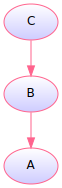

In [53]:
evidentialGraph

$\color{MediumVioletRed}{\text{Case 1: Marginal Dependence}}$

$$
\color{Green}{ B \; \text{is unknown: }\;\;\;\;\;\;\;\;\;\;\; A \longrightarrow B \longrightarrow C}
$$

When the middle node $B$ is unknown / unobserved, there IS an active trail between $A$ and $C$. In other words, there is a dependence between $A$ and $C$ when $B$ is unobserved. This means the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.

In [54]:
# TESTING: active trail method
# NOTE: active trail is symmetric:
assert evidentialModel.is_active_trail(start = 'C', end = 'A', observed = None)
assert evidentialModel.is_active_trail(start = 'A', end = 'C', observed = None)
assert evidentialModel.active_trail_nodes(variables = ['A', 'C']) == {'A': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}

showActiveTrails(model = evidentialModel, variables = ['A', 'C'], observed = None)

A --> C
A --> B
A --> A
C --> C
C --> B
C --> A


$\color{MediumVioletRed}{\text{Case 2: Conditional Independence}}$

$$
\color{DeepSkyBlue}{ B \; \text{is fixed: }\;\;\;\;\;\;\;\;\;\;\; A \; \bot \; C \; | \; B}
$$

When the middle node $B$ is known (fixed / observed), then there is NO active trail between $A$ and $C$. In other words, $A$ and $C$ are locally independent when $B$'s state is observed. This means the probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

In [55]:
# TESTING: active trail method
assert not evidentialModel.is_active_trail(start = 'C', end = 'A', observed = 'B')

assert evidentialModel.active_trail_nodes(variables = ['A', 'C'], observed = 'B') == {'A': {'A'}, 'C': {'C'}}

showActiveTrails(model = evidentialModel, variables = ['A', 'C'], observed = 'B')

A --> A
C --> C


In [56]:
# TESTING: independencies method
indepA = Independencies(['A', 'C', ['B']])
indepC = Independencies(['C', 'A', ['B']])

assert evidentialModel.local_independencies('C') == Independencies()

assert (evidentialModel.local_independencies('A') == indepA and
        indepA == indepC),  \
        "Check: A and C are independent once conditional on B (once B is fixed / observed)"

indepSynonymTable(model = evidentialModel, queryNode = 'A')




             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(A _|_ C | B)     .....     (A _|_ C | B)


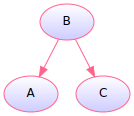

In [57]:
commonCauseGraph

$\color{MediumVioletRed}{\text{Case 1: Marginal Dependence}}$

$$
\color{Green}{ B \; \text{is unknown: }\;\;\;\;\;\;\;\;\;\;\; A \longrightarrow B \longrightarrow C}
$$

When the parent $B$ is unknown / unobserved, there IS an active trail between $A$ and $C$. In other words, there is a dependence between $A$ and $C$ when $B$ is unobserved. This means the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.

In [58]:
# TESTING: active trail method
assert commonCauseModel.is_active_trail(start = 'A', end = 'C', observed = None)

assert commonCauseModel.active_trail_nodes(variables = ['A', 'C']) == {'A': {'A', 'B', 'C'}, 'C': {'A', 'B', 'C'}}

showActiveTrails(model = commonCauseModel, variables = ['A', 'C'], observed = None)

A --> C
A --> B
A --> A
C --> C
C --> B
C --> A


$\color{MediumVioletRed}{\text{Case 2: Conditional Independence}}$

$$
\color{DeepSkyBlue}{ B \; \text{is fixed: }\;\;\;\;\;\;\;\;\;\;\; A \; \bot \; C \; | \; B}
$$

When the parent $B$ is known (fixed / observed), then there is NO active trail between $A$ and $C$. In other words, $A$ and $C$ are locally independent when $B$'s state is observed. This means the probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

In [59]:
# TESTING: active trail method
assert not commonCauseModel.is_active_trail(start = 'A', end = 'C', observed = 'B')

assert commonCauseModel.active_trail_nodes(variables = ['A', 'C'], observed = 'B') == {'A': {'A'}, 'C': {'C'}}

showActiveTrails(model = commonCauseModel, variables = ['A', 'C'], observed = 'B')

A --> A
C --> C


In [60]:
# TESTING: independencies method
indepA = Independencies(['A', 'C', ['B']])
indepC = Independencies(['C', 'A', ['B']])


assert (commonCauseModel.local_independencies('C') == indepC and
        commonCauseModel.local_independencies('A') == indepA and
        indepA == indepC),  \
        "Check: A and C are independent once conditional on B (once B is fixed / observed)"

print(indepSynonymTable(model = commonCauseModel, queryNode = 'A'))
print(indepSynonymTable(model = commonCauseModel, queryNode = 'C'))






             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(A _|_ C | B)     .....     (A _|_ C | B)
None
             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(C _|_ A | B)     .....     (C _|_ A | B)
None


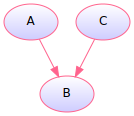

In [61]:
commonEvidenceGraph

$\color{MediumVioletRed}{\text{Case 1: Marginal Independence}}$

$$
\color{DeepSkyBlue}{ B \; \text{is unknown: }\;\;\;\;\;\;\;\;\;\;\; A \; \bot \; C}
$$

When the collider $B$ is unknown / unobserved, there is NO active trail between $A$ and $C$. In other words, $A$ and $C$ are locally independent when $B$ is unobserved. This means the probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is unobserved.

In [62]:
# TESTING: active trail method
assert not commonEvidenceModel.is_active_trail(start = 'A', end = 'C', observed = None)

assert commonEvidenceModel.active_trail_nodes(variables = ['A', 'C']) == {'A': {'A', 'B'}, 'C': {'B', 'C'}}

showActiveTrails(model = commonEvidenceModel, variables = ['A', 'C'], observed = None)

A --> B
A --> A
C --> C
C --> B


In [63]:
# TESTING: independencies method
indepA = Independencies(['A', 'C'])
indepC = Independencies(['C', 'A'])

assert commonEvidenceModel.local_independencies('B') == Independencies()

assert (commonEvidenceModel.local_independencies('C') == indepC and
        commonEvidenceModel.local_independencies('A') == indepA and
        indepA == indepC),  \
        "Check: A and C are marginally independent (independent even when not conditioning / fixing / observing B)"

print(indepSynonymTable(model = commonEvidenceModel, queryNode = 'A'))
print(indepSynonymTable(model = commonEvidenceModel, queryNode = 'C'))

             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(A _|_ C)     .....     (A _|_ C)
None
             INDEPENDENCIES TABLE            
Fancy Notation     .....     Regular Notation
---------------------------------------------
(C _|_ A)     .....     (C _|_ A)
None


**$\color{MediumVioletRed}{\text{Case 2: Conditional Dependence}}$**

$$
\color{Green}{ B \; \text{is fixed: }\;\;\;\;\;\;\;\;\;\;\; A \longrightarrow B \longrightarrow C}
$$

When the collider $B$ is known (fixed / observed), then there IS an active trail between $A$ and $C$. In other words, there is a dependence between $A$ and $C$ when $B$ is observed, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$ is known.

In [64]:
# TESTING: active trail method
assert commonEvidenceModel.is_active_trail(start = 'A', end = 'C', observed = 'B')

assert commonEvidenceModel.active_trail_nodes(variables = ['A', 'C'], observed = 'B') == {'A': {'A', 'C'}, 'C': {'A', 'C'}}

showActiveTrails(model = commonEvidenceModel, variables = ['A', 'C'], observed = 'B')






A --> C
A --> A
C --> C
C --> A


### Study: Simple Student Model's Active Trails: How Influencing Variables can Change Another Variable That is Characteristic (Seems Predetermined)
Here we can influence `diff` and `intel`, while keeping `grades` fixed and can recognize that `intel` is one of the variables that must respond to this change. For instance, if `diff` (difficulty) increases while `grades` are fixed (say observed to be high), then `intel` must be higher than before.

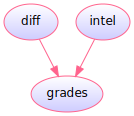

In [65]:
student = BayesianModel()
student.add_nodes_from(['diff', 'intel', 'grades'])
student.add_edges_from([('diff', 'grades'), ('intel', 'grades')])
pgmpyToGraph(student)

In [66]:
assert student.active_trail_nodes('diff') == {'diff': {'diff', 'grades'}}, "Base Case"

# There is an active path from Difficulty --> Intelligence. Influencing difficulty while keeping grades fixed must also change the intelligence of the student
assert student.active_trail_nodes('diff', observed='grades')== {'diff': {'diff', 'intel'}}, "Check: Influencing difficulty while keeping grades fixed must also change the intelligence of the student"



### Study: Larger Student Model's Active Trails

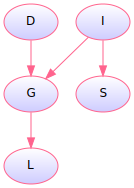

In [67]:
pgmpyToGraph(model)

In [68]:
assert model.active_trail_nodes('D', observed = 'G') == {'D': {'D', 'I', 'S'}}, "Check: Influencing Difficulty (D) must also change the Intelligence (I) and SAT score (S) of the student"
showActiveTrails(model, variables = 'D', observed = 'G')

D --> I
D --> S
D --> D


In [69]:
assert model.active_trail_nodes('I', observed = ['G', 'S']) == {'I': {'D', 'I'}}, "Check: Influencing Inteligence (I) while keeping Grade (G) and SAT score (S) fixed must influence the Difficulty (D) of the test and intelligence (I) of the student"

showActiveTrails(model, variables = 'I', observed = ['G', 'S'])

I --> D
I --> I


In [70]:
assert model.active_trail_nodes('I', observed = 'G') == {'I': {'D', 'I', 'S'}}, "Check: Influencing Intelligence (I) while keeping Grades (G) fixed must also influence Grades (G), Intelligence (I), and Letter of recommendation (L)" # difficulty is not influenced
showActiveTrails(model, variables = 'I', observed = 'G')

I --> D
I --> S
I --> I


In [71]:
assert model.active_trail_nodes('I', observed = 'S') == {'I': {'G', 'I', 'L'}}, "Check: Influencing Intelligence (I) while keeping SAT (S) fixed must also influence Grades (G), Intelligence (I) and Letter (L) received" # difficulty is not influenced

showActiveTrails(model, variables = 'I', observed = 'S')

I --> G
I --> L
I --> I


In [72]:
assert model.active_trail_nodes('L', observed = ['D', 'G']) == {'L': {'L'}}, "Check: Influencing Letter (L) while keeping Difficulty (D) and Grade (G) fixed effectively blocks other changes."
showActiveTrails(model, variables = 'L', observed = ['D', 'G'])

L --> L


In [73]:
assert model.active_trail_nodes('L', observed = ['G', 'I']) == {'L': {'L'}}

showActiveTrails(model, variables = 'L', observed = ['I', 'G'])

L --> L


In [74]:
assert model.active_trail_nodes('L', observed = ['S', 'I']) == {'L': {'D', 'G', 'L'}}

showActiveTrails(model, variables = 'L', observed = ['S', 'I'])




L --> G
L --> L
L --> D


## 3. Joint Distribution Represented by the Bayesian Network
Computing the Joint Distribution from the Bayesian Network, `model`:

From the **chain rule of probability (also called and rule):**
$$
P(A, B) = P(B) \cdot P(A \; | \; B)
$$
Now in this case for the `model`:
$$
\begin{align}
P(D, I, G, L, S)
&= P(L \; | \; D, I, G, S) \cdot P(D, I, G, S) \\
&= P(L \; | \; D, I, G, S) \cdot {\color{cyan} (} P(S \; | \; D, I, G) \cdot P(D, I, G) {\color{cyan} )} \\
&= P(L \; | \; D, I, G, S) \cdot P(S \; | \; D, I, G) \cdot {\color{cyan} (}P(G \; | \; D, I) \cdot P(D, I){\color{cyan} )} \\
&= P(L \; | \; D, I, G, S) \cdot P(S \; | \; D, I, G) \cdot P(G \; | \; D, I) \cdot {\color{cyan} (}P(D \; | \; I) \cdot P(I){\color{cyan} )} \\
\end{align}
$$

In [75]:
from src.utils.NetworkUtil import *

probChainRule(condAcc = ['L', 'S', 'G', 'D', 'I'])

'P(L | S, G, D, I) * P(S | G, D, I) * P(G | D, I) * P(D | I) * P(I)'

Applying the local independence conditions to the above equation we get:
$$
\begin{align}
P(D, I, G, L, S)
&= P(L \; | \; D, I, G, S) \cdot P(S \; | \; D, I, G) \cdot P(G \; | \; D, I) \cdot {\color{cyan} (}P(D \; | \; I) \cdot P(I){\color{cyan} )} \\
&= P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D ) \cdot P(I)
\end{align}
$$

In [76]:
model.local_independencies('D')
model.local_independencies('I')
model.local_independencies('G')
model.local_independencies('S')
str(model.local_independencies('L'))

# TODO reduction function to do
# 0. split by "*"

# For each probExpr P(frontNode | ...), get the frontNode

# 1. get local independencies of a NODE L
# 2. make to string
# 3. split at the _|_ and | signs, the ones between are beforeCond letters and the ones after | are afterCond letters
# 4. analyze the expression P(L | D,I,G,S): filter the after-cond part here and keep only the afterCond from step 3, eliminating the letters that are in beforeCond from step 3
# 5. reconstruct the new expression with the P(L | keptLetters)

### for general multiplied expression, first split by "*" then apply this mini function

'(L _|_ D, S, I | G)'

From the above equation we can clearly see that the Joint Distribution over all variables is just the product of all the CPDs in the network. Hence, encoding the inependencies in the Joint Distribution in a graph structure helped us in reducing the number of parameters that we need to store.

In [77]:
# Very simple, simplistic (not always right?) way to get the cpd name: just putting the second variable second
def cpdName(model: BayesianModel, node: Variable) -> str:
    variables = model.get_cpds(node).variables
    if len(variables) == 1:
        return 'P('  + variables[0] + ')'
    else:
        return 'P(' + variables[0] + " | " + ', '.join(variables[1:]) + ')'

# The simplified names:
assert cpdName(model, 'L') == 'P(L | G)'
assert cpdName(model, 'S') == 'P(S | I)'
assert cpdName(model, 'G') == 'P(G | I, D)'
assert cpdName(model, 'D') == 'P(D)'
assert cpdName(model, 'I') == 'P(I)'

## 4. Inference in Bayesian Models
So far we talked about represented Bayesian Networks.

Now let us do inference in a  Bayesian model and predict values using this model over new data points for ML tasks.

**Inference:** in inference we try to answer probability queries over the network given some other variables. Example: we might want to know the probable grade of an intelligent student in a difficult class given that he scored well on the SAT. So for computing these values from a Joint Distribution we will ahve to reduce over the given variables: $I = 1, D = 1, S = 1$, and then marginalize over the other variables we didn't ask about (L) to get the distribution for the variable we asked about (G), so to get the distribution: $P(G \; | \; I = 1, D = 1, S = 1)$.

But doing marginalize and reduce operations on the complete Joint Distribution is computationally expensive since we need to iterate over the whole table for each operation and the table is exponential in size to the number of variables. But we can exploit the independencies (like above) to break these operations in smaller parts, increasing efficiency of calculation.

### Variable Elimination
**Variable Elimination:** a method of inference in graphical models.

For our model, we know that the joint distribution (reduced using local independencies) is:
$$
\begin{align}
P(D, I, G, L, S) = P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I)
\end{align}
$$
**Example 1: Compute $P(G)$**

Now say we want to compute the probability of just the grade $G$. That means we must **marginalize** over all other variables:
$$
\begin{align}
P(G) &= \sum_{D,I,L,S} P(D,I,G,L,S) \\
&= \sum_{D,I,L,S} P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I) \\
&= \sum_D \sum_I \sum_L \sum_S P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I) \\
&= \sum_D P(D) \sum_I P(G \; | \; D, I) \cdot P(I) \sum_S P(S \; | \; I) \sum_L P(L \; | \; G)
\end{align}
$$
In the above expression, to simplify the sumation, we just brought the summation with respect to a particular variable as far as it could go (as inner-deep as it could go, without putting the summation with respect to the variable past the probability expression that included that variable)

By pushing the summations inside we have saved a lot of computation because we now have to iterate over much smaller tables.

Taking an example for inference using Variable Elimination in pgmpy:

In [78]:
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor
from pgmpy.factors.discrete.JointProbabilityDistribution import JointProbabilityDistribution

from src.utils.NetworkUtil import *

jpd: JointProbabilityDistribution = jointDistribution(model)

jpd.marginalize(variables = ['L', 'S', 'D', 'I'])
print(jpd)

infer = VariableElimination(model = model)
inferResult: DiscreteFactor = infer.query(variables = ['G'])
print(inferResult)

  0%|          | 0/4 [00:00<?, ?it/s]

+------+--------+
| G    |   P(G) |
+======+========+
| G(0) | 0.3620 |
+------+--------+
| G(1) | 0.2884 |
+------+--------+
| G(2) | 0.3496 |
+------+--------+


Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 689.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: L:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: D:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: S:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: I:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: I: 100%|██████████| 4/4 [00:00<00:00, 193.34it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.3620 |
+------+----------+
| G(B) |   0.2884 |
+------+----------+
| G(C) |   0.3496 |
+------+----------+


**Example 2:** Compute $P(G \; | \; D = 0, I = 1)$

Have already that:
$$
\begin{align}
P(G)
&= \sum_D \sum_I \sum_L \sum_S P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I) \\
&= \sum_D P(D) \sum_I P(G \; | \; D, I) \cdot P(I) \sum_S P(S \; | \; I) \sum_L P(L \; | \; G)
\end{align}
$$
To compute $P(G \; | \; D = 0, I = 1)$, we must substitute the value $D = 0, I = 1$ wherever possible and then move the summations:
$$
\begin{align}
P(G \; | \; D = 0, I = 1) \\
&= \sum_D \sum_I \sum_L \sum_S P(L \; | \; G) \cdot P(S \; | \; I = 1) \cdot P(G \; | \; D = 0, I = 1) \cdot P(D = 0) \cdot P(I = 1) \\
&= \sum_L \sum_S P(L \; | \; G) \cdot P(S \; | \; I = 1) \cdot P(G \; | \; D = 0, I = 1) \cdot P(D = 0) \cdot P(I = 1) \\
&= P(D = 0) \cdot P(I = 1) \cdot P(G \; | \; D = 0, I = 1)  \;\; \cdot \;\; \sum_L P(L \; | \; G) \cdot \sum_S P(S \; | \; I = 1)  \\
\end{align}
$$
In pgmpy we just need to pass the extra `evidence` argument, when we want to calculate conditional distributions like these:

In [79]:

conditionalG = infer.query(variables = ['G'], evidence = {'D': 'Easy', 'I' : 'Intelligent'})
print(conditionalG)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 374.14it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: L:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: S:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: S: 100%|██████████| 2/2 [00:00<00:00, 197.08it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


**Predicting Values from New Data Points:**

This is similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probability distribution,  we are interestd in getting the **most probable state of the variable**.

Pgmpy calls this the MAP query (maximum a posterior?):

**Key concept:** bayesian posterior update
* similar to BayesiaLab's setting of marginal probability states and getting the updated marginals of other variables.
* similar to CausalNex's .query() method, where we can pass a `dict` of observed states

In [80]:
# Just the simple prediction for node G, from marginal distribution, no observed value given:
infer.map_query(['G'])

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 1100.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: L:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: D:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: S:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: I:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: I: 100%|██████████| 4/4 [00:00<00:00, 183.82it/s]

{'G': 'A'}

In [81]:
# The prediction for node G, given observed values D = Hard, I = Intelligent (so posterior update with this new observation / evidence)
infer.map_query(['G'], evidence={'D': 'Hard', 'I': 'Intelligent'})

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 434.46it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: L:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: S:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: S: 100%|██████████| 2/2 [00:00<00:00, 235.82it/s]

{'G': 'A'}

In [82]:
#model.get_cpds('L').state_names
infer.map_query(['G'], evidence={'D': 'Hard', 'I': 'Intelligent', 'L': 'Bad', 'S': 'Bad'})

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'C'}

In [83]:
# Grade result when student is intelligent, test was hard, letter is bad, SAT score is Good:
infer.map_query(['G'], evidence={'D': 'Hard', 'I': 'Intelligent', 'L': 'Bad', 'S': 'Good'})

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'C'}